# DCGAN - Pixel character generation
Based on the pytorch DCGAN tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- Added soft labels
- Added Wesserstein loss
- Added dropout to discriminator

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

In [55]:
# Set random seed for reproducibility
manualSeed = '999'
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
from google.colab import files
uploaded = files.upload()
!unzip -q data.zip #uzipping dataset

Saving data.zip to data.zip


In [0]:
dataroot = "."

workers = 2 # Number of workers for dataloader
batch_size = 64 
image_size = 64

channels = 3

latent_size = 84
feature_map_size = 48
num_epochs = 30

lr = 0.0002
beta1 = 0.5
ngpu = 1

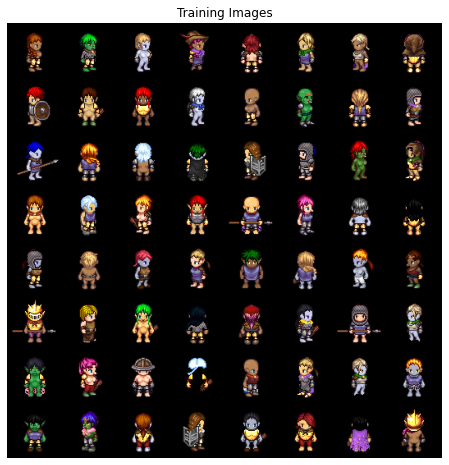

In [358]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![alt text](https://pytorch.org/tutorials/_images/dcgan_generator.png)

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            nn.ConvTranspose2d( feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
 
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [361]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(84, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [362]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Conv2d(384, 1, kernel_size=(4, 4), stride

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()
def wasserstein_loss(y_true, y_pred):
	return torch.mean(y_true * y_pred)
 

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [364]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # if epoch%100 == 99:
    #   lr*=0.9
    #   optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    #   optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        out_size = output.size(0)

        label = ((1.05-0.95)*torch.rand((b_size, 1)) + 0.95).to(device)

        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)

        label = (0.1*torch.rand((b_size, 1))).to(device)

        output = netD(fake.detach()).view(-1)
        errD_fake =  criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/30][0/57]	Loss_D: 1.8412	Loss_G: 1.4511	D(x): 0.3695	D(G(z)): 0.4448 / 0.3045
[0/30][50/57]	Loss_D: 0.4074	Loss_G: 7.7901	D(x): 0.9549	D(G(z)): 0.0026 / 0.0009
[1/30][0/57]	Loss_D: 0.4824	Loss_G: 7.6102	D(x): 0.9255	D(G(z)): 0.0004 / 0.0010
[1/30][50/57]	Loss_D: 0.8230	Loss_G: 9.7698	D(x): 0.9725	D(G(z)): 0.4856 / 0.0001
[2/30][0/57]	Loss_D: 0.3609	Loss_G: 6.9659	D(x): 0.9259	D(G(z)): 0.0133 / 0.0019
[2/30][50/57]	Loss_D: 0.7634	Loss_G: 11.1765	D(x): 0.7662	D(G(z)): 0.0005 / 0.0000
[3/30][0/57]	Loss_D: 0.3644	Loss_G: 3.2921	D(x): 0.8891	D(G(z)): 0.0361 / 0.0526
[3/30][50/57]	Loss_D: 0.3540	Loss_G: 5.0214	D(x): 0.9043	D(G(z)): 0.1119 / 0.0095
[4/30][0/57]	Loss_D: 0.3356	Loss_G: 4.2566	D(x): 0.8974	D(G(z)): 0.0535 / 0.0197
[4/30][50/57]	Loss_D: 0.3715	Loss_G: 2.9930	D(x): 0.9039	D(G(z)): 0.1253 / 0.0728
[5/30][0/57]	Loss_D: 0.3913	Loss_G: 4.9205	D(x): 0.9682	D(G(z)): 0.2504 / 0.0147
[5/30][50/57]	Loss_D: 0.3950	Loss_G: 3.4419	D(x): 0.9068	D(G(z)): 0.0437 / 0.0467
[6/30][0/57]	Loss_D: 

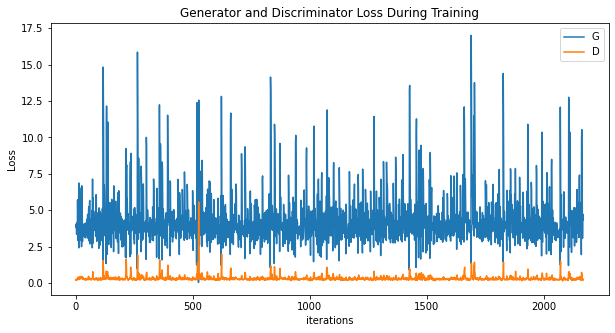

In [353]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

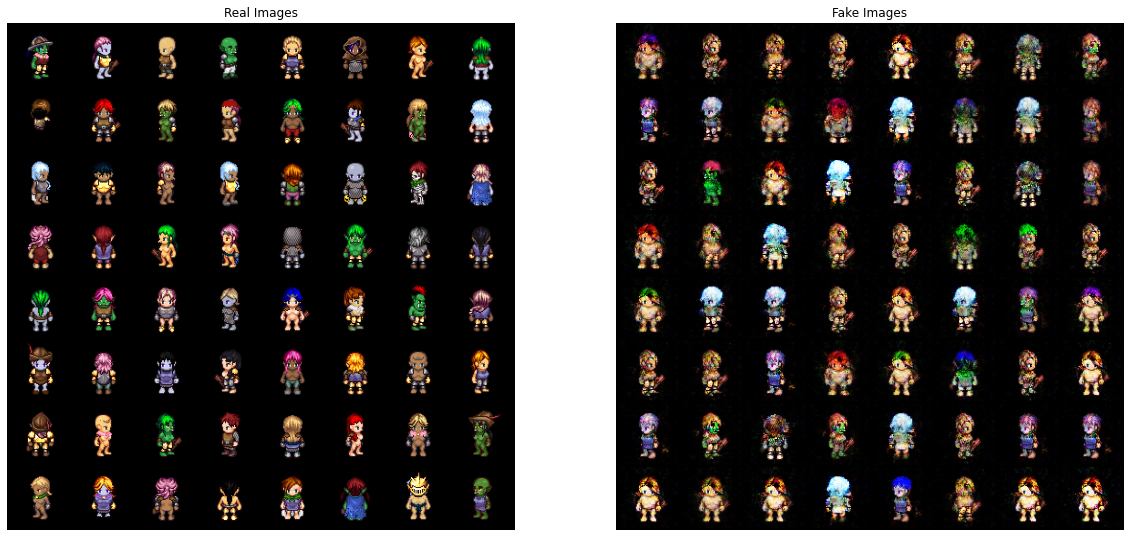

In [354]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())